In [1]:
import sys
import os

# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

import warnings
warnings.filterwarnings('ignore')


In [2]:
import deeppy as dp


In [3]:
import h5py
import torch
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt




import torch
import torch.optim as optim
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from deeppy import IngpData, LearnFrame, DatasetLoader

import glob

In [2]:
class GridEncoder():
    def __init__(self, levels = 16, base_resolution = 16,  align_corners = True, hashmap_size = 2**19):
        super(GridEncoder, self).__init__()
        self.base_resolution = torch.tensor(base_resolution)
        self.align_corners = align_corners
        
        self.num_levels = levels
        self.levels = torch.arange(levels)
        
        self.per_level_scale = torch.exp2(torch.log2(2048 / self.base_resolution) / (self.num_levels - 1))
        
        
        
        #(16,1)
        self.resolutions = torch.ceil(self.base_resolution * (self.per_level_scale ** self.levels)).to(torch.int64).unsqueeze(1)
        
        self.hashmap_sizes = torch.min(self.resolutions ** 3, torch.tensor(hashmap_size)).view(1,1, self.levels[-1]+1,1)

        self.hash_table_indices_end = torch.cumsum(self.hashmap_sizes.flatten(), dim=0).to(dtype=torch.int64)
        self.hash_table_indices_start = torch.cat([torch.tensor([0]), self.hash_table_indices_end[:-1]])
        #(1,16,1)
        scale = torch.exp2(self.levels * torch.log2(self.per_level_scale)) * self.base_resolution - 1.0
        self.scale = scale.unsqueeze(1).unsqueeze(0)
        
        # Get 8 offset combinations: all binary 3D offsets (0 or 1 for each axis)
        #(8,3)
        self.offsets = torch.tensor([[i, j, k] for i in [0, 1] for j in [0, 1] for k in [0, 1]], dtype=torch.int64)  
        
        # Reshape for broadcasting: [1, 1, 8, 3]
        self.offsets = self.offsets.view(1, 1, -1,3)
    def __call__(self,xyz):
        return self.forward(xyz)
    def fast_hash(self,xyz_corners, primes=(1, 2654435761, 805459861, 3674653429, 2097192037, 1434869437, 2165219737)):
        primes = torch.tensor(primes[:xyz_corners.shape[-1]]).to(torch.int64).unsqueeze(0)

        xyz_primes = xyz_corners * primes
        return np.bitwise_xor.reduce(xyz_primes, axis=1).unsqueeze(1)
    def forward(self, xyz):
        #Input in Shape (B,D)
        B,D = xyz.shape[0], xyz.shape[1]
        level = self.num_levels
        #(16B, D)
        xyz_per_level = xyz.repeat_interleave(level, dim=0).view(B, level, D)
        
        weights = self.compute_corner_weights(xyz_per_level)
        #(512,16,1,3)
        xyz_scaled = torch.floor((xyz_per_level * self.scale) + (0.0 if self.align_corners else 0.5))
        xyz_scaled = xyz_scaled.to(torch.int64).unsqueeze(2)

        #(512,16,8,3)
        xyz_corners = xyz_scaled + self.offsets
        orig_shape = xyz_corners.shape[:-1]

        #(-1,3)
        xyz_corners = xyz_corners.view(-1,3)

        #(B*16*8,1)
        hashes = self.fast_hash(xyz_corners)
        
        #(B,8,16,1)
        hashes = hashes.view(B,8,16,1)
        

        indices = hashes % self.hashmap_sizes
        
        #return (B,8,16,1)
        indices = indices +  self.hash_table_indices_start.view(1,1,-1,1)
        return indices, weights
    

    def compute_corner_weights(self,xyz_per_level):
        """
        Args:
            points: [N, d] float — continuous positions
        Returns:
            weights: [N, 2^d] — interpolation weights for each corner
        """
        print(xyz_per_level.shape)
        xyz_scaled = (xyz_per_level * ge.scale) + (0.0 if ge.align_corners else 0.5)
        
        # (512,16,3)
        w = xyz_scaled - torch.floor(xyz_scaled)  # fractional offsets [0,1)
        
        #(512*16,3)
        w = w.reshape(-1,3)
        N = w.shape[0]

        # Expand to [N, 2^d, d]
        w_exp = w.unsqueeze(1).expand(-1, 2 ** 3, -1)              # [N, 2^d, d]

        offsets = ge.offsets.squeeze(0).expand(N, -1, -1)    # [N, 2^d, d]


        # For each dimension: select w_l or (1 - w_l) depending on offset
        weights = torch.where(offsets.bool(), w_exp, 1 - w_exp)    # [N, 2^d, d]

        # Multiply over d dimensions to get final weight per corner
        weights = weights.prod(dim=-1)    
        weights = weights.reshape(512,16,8)
        
        return weights.unsqueeze(-1)


In [3]:
ge = GridEncoder()
xyz = torch.rand((512,3))

indices, weights = ge(xyz)


torch.Size([512, 16, 3])


In [85]:
indices.shape

torch.Size([512, 8, 16, 1])

In [86]:
weights.shape

torch.Size([512, 16, 8, 1])

In [50]:
indices.shape

torch.Size([512, 8, 16, 1])

In [49]:
ge = GridEncoder()
xyz = torch.rand((512,3))

indices = ge(xyz)

B,D = xyz.shape[0], xyz.shape[1]
level = 16
#(16B, D)
xyz_per_level = xyz.repeat_interleave(level, dim=0).view(B, level, D)
#(512,16,1,3)
xyz_scaled = ((xyz_per_level * ge.scale) + (0.0 if ge.align_corners else 0.5))



In [47]:
xyz_scaled.shape

torch.Size([512, 16, 3])

In [61]:
# (512,16,3)
N = w.shape[0]
w = xyz_scaled - torch.floor(xyz_scaled)  # fractional offsets [0,1)

#(512*16,3)
w = w.reshape(-1,3)


# Expand to [N, 2^d, d]
w_exp = w.unsqueeze(1).expand(-1, 2 ** 3, -1)              # [N, 2^d, d]

offsets = ge.offsets.squeeze(0).expand(N, -1, -1)    # [N, 2^d, d]


# For each dimension: select w_l or (1 - w_l) depending on offset
weights = torch.where(offsets.bool(), w_exp, 1 - w_exp)    # [N, 2^d, d]

# Multiply over d dimensions to get final weight per corner
weights = weights.prod(dim=-1)    
weights = weights.reshape(512,16,8)


torch.Size([512, 16, 8])


In [4]:
CONFIG = {
    'hash_encoding': {
        'num_levels': 16,
        'level_dim': 2,
        'input_dim': 3,
        'log2_hashmap_size': 19,
        'base_resolution': 16
    },
    'mlp': {
        'num_layers': 3,  # Number of layers in geometric MLP
        'hidden_dim': 64,  # Hidden dimension size
    }
}

def load_torch_weights(file_path):
    """Load model weights from a checkpoint file."""
    try:
        weights = torch.load(file_path, map_location='cpu')
        return weights['model']
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None
        
def extract_hash_encoding_structure(model_weights, num_levels=16, level_dim=2, input_dim=3, log2_hashmap_size=19, base_resolution=16):
    """
    Extract and organize hash encoding weights into hierarchical structure.
    
    Args:
        model_weights (dict): The loaded model weights dictionary
        num_levels (int): Number of levels in hash encoding
        level_dim (int): Dimension of encoding at each level
        input_dim (int): Input dimension (typically 3 for 3D)
        log2_hashmap_size (int): Log2 of maximum hash table size
        base_resolution (int): Base resolution of the grid
        
    Returns:
        dict: Hierarchical structure of hash encoding weights
    """
    # Extract hash encoding embeddings
    embeddings = model_weights['_orig_mod.grid_encoder.embeddings']
    
    # Calculate per-level parameters
    max_params = 2 ** log2_hashmap_size
    per_level_scale = np.exp2(np.log2(2048 / base_resolution) / (num_levels - 1))
    
    # Initialize structure to store weights
    hash_structure = {}
    offset = 0
    
    for level in range(num_levels):
        # Calculate resolution at this level
        resolution = int(np.ceil(base_resolution * (per_level_scale ** level)))
        
        # Calculate number of parameters for this level
        params_in_level = min(max_params, (resolution) ** input_dim)
        params_in_level = int(np.ceil(params_in_level / 8) * 8)  # make divisible by 8
        
        # Extract weights for this level
        level_weights = embeddings[offset:offset + params_in_level]
        
        # Store level information
        hash_structure[f'level_{level}'] = {
            'resolution': resolution,
            'num_params': params_in_level,
            'weights': level_weights,
            'weights_shape': level_weights.shape,
            'scale': per_level_scale ** level
        }
        
        offset += params_in_level
    
    # Add global information
    hash_structure['global_info'] = {
        'total_params': offset,
        'embedding_dim': level_dim,
        'base_resolution': base_resolution,
        'max_resolution': int(np.ceil(base_resolution * (per_level_scale ** (num_levels-1)))),
        'per_level_scale': per_level_scale
    }
    
    return hash_structure

def extract_mlp_weights(model_weights):
    """Extract geometric and view-dependent MLP weights from the model."""
    geometry_layers = {}
    view_mlp_layers = {}
    
    # Extract geometry MLP weights
    for i in range(CONFIG['mlp']['num_layers']):
        weight_key = f'_orig_mod.grid_mlp.net.{i}.weight'
        bias_key = f'_orig_mod.grid_mlp.net.{i}.bias'
        
        if weight_key in model_weights:
            geometry_layers[f'layer_{i}'] = {
                'weights': model_weights[weight_key],
                'shape': model_weights[weight_key].shape
            }
            
            if bias_key in model_weights:
                geometry_layers[f'layer_{i}']['bias'] = model_weights[bias_key]
    
    # Extract view-dependent MLP weights
    for i in range(CONFIG['mlp']['num_layers']):
        weight_key = f'_orig_mod.view_mlp.net.{i}.weight'
        bias_key = f'_orig_mod.view_mlp.net.{i}.bias'
        
        if weight_key in model_weights:
            view_mlp_layers[f'layer_{i}'] = {
                'weights': model_weights[weight_key],
                'shape': model_weights[weight_key].shape
            }
            
            if bias_key in model_weights:
                view_mlp_layers[f'layer_{i}']['bias'] = model_weights[bias_key]
    
    return {
        'geometry_mlp': geometry_layers,
        'view_mlp': view_mlp_layers
    }

# Example usage
nerf_path = "../../data/1Story/z_000_000_240/checkpoints"
nerf = load_torch_weights(nerf_path + "/final.pth")
mlp_weights = extract_mlp_weights(nerf)
mrhe_by_layer = extract_hash_encoding_structure(nerf)

In [5]:
nerf

OrderedDict([('_orig_mod.aabb_train', tensor([-4., -4., -4.,  4.,  4.,  4.])),
             ('_orig_mod.aabb_infer', tensor([-4., -4., -4.,  4.,  4.,  4.])),
             ('_orig_mod.density_grid',
              tensor([[ 38.6418,  36.7779,  99.9596,  ...,  29.5234,  16.1232,  18.7200],
                      [ 36.8520,  16.5457,  26.1915,  ...,  20.2515, 109.0064,  58.5641],
                      [  8.6298,  10.3339,   8.7417,  ...,  16.4244,  12.1553,  15.7462]])),
             ('_orig_mod.density_bitfield',
              tensor([247, 255, 252,  ...,  81, 249, 238], dtype=torch.uint8)),
             ('_orig_mod.grid_encoder.embeddings',
              tensor([[ 0.2054, -0.1916],
                      [-0.0194,  0.0622],
                      [ 0.1761, -0.1455],
                      ...,
                      [ 1.1601, -0.5767],
                      [ 1.2920,  0.0303],
                      [ 0.6234, -0.3979]])),
             ('_orig_mod.grid_encoder.offsets',
              tensor([  

# Try Grid encoder

In [ ]:
#LOAD HALF PRECISION ALWAYS

from deeppy.data.base import Base


from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import glob
import json
import numpy as np
import safetensors.torch as sf 

class GridEncoder():
    def __init__(self, levels = 16, base_resolution = 16,  align_corners = True, hashmap_size = 2**19):
        super(GridEncoder, self).__init__()
        self.base_resolution = torch.tensor(base_resolution)
        self.align_corners = align_corners
        
        self.num_levels = levels
        self.levels = torch.arange(levels)
        
        self.per_level_scale = torch.exp2(torch.log2(2048 / self.base_resolution) / (self.num_levels - 1))
        
        
        
        #(16,1)
        self.resolutions = torch.ceil(self.base_resolution * (self.per_level_scale ** self.levels)).to(torch.int64).unsqueeze(1)
        
        self.hashmap_sizes = torch.min(self.resolutions ** 3, torch.tensor(hashmap_size)).view(1,1, self.levels[-1]+1,1)

        self.hash_table_indices_end = torch.cumsum(self.hashmap_sizes.flatten(), dim=0).to(dtype=torch.int64)
        self.hash_table_indices_start = torch.cat([torch.tensor([0]), self.hash_table_indices_end[:-1]])
        #(1,16,1)
        scale = torch.exp2(self.levels * torch.log2(self.per_level_scale)) * self.base_resolution - 1.0
        self.scale = scale.unsqueeze(1).unsqueeze(0)
        
        # Get 8 offset combinations: all binary 3D offsets (0 or 1 for each axis)
        #(8,3)
        self.offsets = torch.tensor([[i, j, k] for i in [0, 1] for j in [0, 1] for k in [0, 1]], dtype=torch.int64)  
        
        # Reshape for broadcasting: [1, 1, 8, 3]
        self.offsets = self.offsets.view(1, 1, -1,3)
    def __call__(self,xyz):
        return self.forward(xyz)
    def fast_hash(self,xyz_corners, primes=(1, 2654435761, 805459861, 3674653429, 2097192037, 1434869437, 2165219737)):
        primes = torch.tensor(primes[:xyz_corners.shape[-1]]).to(torch.int64).unsqueeze(0)

        xyz_primes = xyz_corners * primes
        return np.bitwise_xor.reduce(xyz_primes, axis=1).unsqueeze(1)
    def forward(self, xyz):
        #Input in Shape (B,D)
        B,D = xyz.shape[0], xyz.shape[1]
        level = self.num_levels
        #(16B, D)
        xyz_per_level = xyz.repeat_interleave(level, dim=0).view(B, level, D)
        #(512,16,1,3)
        xyz_scaled = torch.floor((xyz_per_level * self.scale) + (0.0 if self.align_corners else 0.5))
        xyz_scaled = xyz_scaled.to(torch.int64).unsqueeze(2)

        #(512,16,8,3)
        xyz_corners = xyz_scaled + self.offsets
        orig_shape = xyz_corners.shape[:-1]

        #(-1,3)
        xyz_corners = xyz_corners.view(-1,3)

        #(B*16*8,1)
        hashes = self.fast_hash(xyz_corners)
        
        #(B,8,16,1)
        hashes = hashes.view(B,8,16,1)
        

        indices = hashes % self.hashmap_sizes
        
        #return (B,8,16,1)
        indices = indices +  self.hash_table_indices_start.view(1,1,-1,1)
        return indices
    

class IngpData(Dataset):
    def __init__(self, data_path, config, window_size = None, token_size = None, max_layer_width = 64, device = None):
        self.data_path = data_path
        self.config = config

        base_resolution = self.config['hash_encoding']["base_resolution"]  # Base resolution of the grid encoder
        num_levels = self.config['hash_encoding']["num_levels"]  # Number of levels in the grid encoder
        self.grid_encoder = GridEncoder(base_resolution=base_resolution, levels=num_levels, hashmap_size= 2**19)

        self.window_size = window_size
        self.hash_chunk_size = self.window_size - 53 - 1# 53 is the size of the MLP tokens # And one for rotation index
        self.token_size = token_size
        self.max_layer_width = max_layer_width

        if self.token_size % self.max_layer_width != 0:
            raise ValueError("Invalid token size or max_layer_width")
        
        self.load_object_paths()
        
        self.max_positions = self[0][1].max(axis=0).values + 2
        hash_table_indices_end = self.grid_encoder.hash_table_indices_end
        self.max_positions[2] = (hash_table_indices_end[-1]  - hash_table_indices_end[-2] ).item() + 1


    def __len__(self):
        return len(self.all_objects_2d)
    
    def __getitem__(self, idx):
        #Random index
        #Sample (window_size - hash_chunk_size )points in 3D space (512,3)
        points = torch.rand((self.hash_chunk_size, 3))
        
        #Get 2 random views of the object
        object_parent_path = self.all_objects_2d[idx]
        idx_child = torch.randperm(len(object_parent_path))[:2]

        obj1_path, obj_1_transform = object_parent_path[idx_child[0]]
        obj2_path, obj_2_transform = object_parent_path[idx_child[1]] 

        [t1,p1,m1], r1 = self.load_weights(obj1_path, points), obj_1_transform
        (t2,p2,m2), r2 = self.load_weights(obj2_path, points), obj_2_transform

        return t1, p1, m1, r1, t2, p2, m2, r2

    def load_weights(self, file_path, points):
        file_path = file_path.replace("final.pth", "")
        # 3D points = (B,3)
        B = points.shape[0]

        #(B,8,16,1)
        indices = self.grid_encoder(points)
        indices_flat = indices.flatten()

        #[B*16*8,2]
        embeddings = np.load(file_path + "hash.npy", mmap_mode='r')
        hash_tokens = torch.from_numpy(embeddings[indices_flat.numpy()])
        
        #(B,256)
        hash_tokens = hash_tokens.reshape(B,-1)
        hash_masks = torch.ones_like(hash_tokens)
        #(B,128)
        hash_pos = indices.reshape(B,-1)
        print(hash_pos.shape)

        

        #(6 , X , token_size) -> (1, 6X, token_size)
        data = sf.load_file(file_path + "mlp.safetensors")
        mlp_tokens, mlp_masks = data["tokens"], data["masks"]
        mlp_pos = torch.zeros((mlp_tokens.shape[0],1))

        rot_t = torch.zeros((1, self.token_size))
        rot_m = torch.zeros_like(rot_t)
        rot_p = torch.rand((1,3))
        return torch.vstack([rot_t,hash_tokens, mlp_tokens]), torch.vstack([rot_p, hash_pos, mlp_pos]), torch.vstack([rot_m, hash_masks,mlp_masks])
    
    def tokenize_mlp_layer(self, w, layer_ix = None):
        
        mask = torch.ones_like(w)
        
        pad = self.max_layer_width - w.shape[1]
        # w - > (x , max_layer_width)
        if pad > 0:
            w = nn.functional.pad(w, (0, pad))
            mask = nn.functional.pad(mask, (0,pad))

        n_layers_per_token = (self.token_size // self.max_layer_width)
        pad_axis_0 = (n_layers_per_token - (w.shape[0] % n_layers_per_token)) % n_layers_per_token
        
        # (x, max_layer_width) -> (n_layers_per_token *k , max_layer_width)
        if pad_axis_0 > 0:
            w = torch.cat([w, torch.zeros(pad_axis_0, w.shape[1])], dim=0)
            mask = torch.cat([mask, torch.zeros(pad_axis_0, mask.shape[1])], dim=0)

        #(Group each 4 rows into one row)
        w = w.view(-1, n_layers_per_token , self.max_layer_width).view(-1,self.token_size)
        mask = mask.view(-1, n_layers_per_token , self.max_layer_width).view(-1,self.token_size)
        
        pos = torch.zeros((w.shape[0], 3), dtype=torch.int64)
        pos[:,1] = torch.full_like(pos[:,0], layer_ix)
        pos[:,2] = torch.arange(w.shape[0])
        return w,pos,mask
    

    def load_object_paths(self): 
        self.objects = glob.glob(self.data_path + "/*")
        self.all_objects_2d = []
        self.all_objects = []
        #For all objects
        for o in self.objects:
            #Get paths for (up to) 6 different views
            obj_paths = glob.glob(o + "/**/*.npy",  recursive=True)
            #If no augmentation, skip
            if len(obj_paths) <= 1:
                continue
            #From the folder name calculate the transform
            transforms =  [[float(m) for m in k.split("/")[-3].split("_")[1:]] for k in obj_paths]
            transforms = torch.deg2rad(torch.tensor(transforms, dtype=torch.float32))  # Convert degrees to radians
            
            obj_paths = [o.replace("hash.npy","") for o in obj_paths]
            this_object = list(zip(*[obj_paths, transforms]))
            
            self.all_objects.extend(this_object)
            self.all_objects_2d.append(this_object)

        

    
    # ===========================================================



In [ ]:


data_config = {
    'hash_encoding': {
        'num_levels': 16,
        'level_dim': 2,
        'input_dim': 3,
        'log2_hashmap_size': 19,
        'base_resolution': 16
    },
    'mlp': {
        'num_layers': 3,  # Number of layers in geometric MLP
        'hidden_dim': 64,  # Hidden dimension size
    }
}

window_size = 512
batch_size = 16
input_dim = 256

dataset_config = {
    "data_path": "../../data/",
    "config": data_config,
    "window_size": window_size,
    "token_size": input_dim,
}



data = DatasetLoader(IngpData(**dataset_config), batch_size = batch_size, num_workers = 24 , splits = [0.9, 0.1, 0])
print(data.data.max_positions)

In [81]:
X = data.train_data()

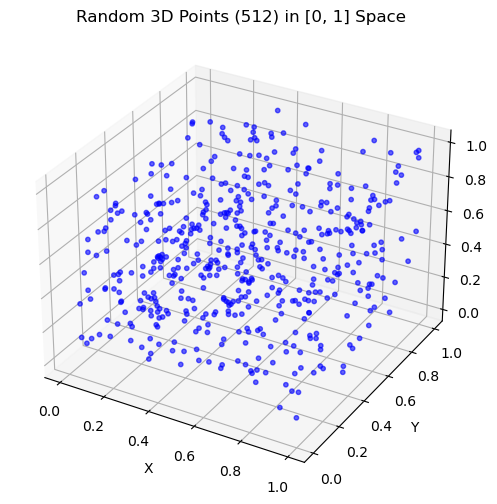

In [356]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random 3D points in [0, 1]
batch_size = 512
points = torch.rand(batch_size, 3)  # Shape: [batch_size, 3]

# Plot in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=10, c='blue', alpha=0.6)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title(f"Random 3D Points ({batch_size}) in [0, 1] Space")

plt.show()


# Write HDF5

In [2]:
from safetensors.torch import save_file, load_file

objects = glob.glob("../../data/*")
files = []
for obj in objects:
    files += glob.glob(obj +  "/*/checkpoints/final.pth")

files.sort()
len(files)

2052

In [3]:
def tokenize_mlp_layer(w):  
    mask = torch.ones_like(w)
    
    max_layer_width = 64
    token_size = 256
    
    pad = max_layer_width - w.shape[1]
    # w - > (x , max_layer_width)
    if pad > 0:
        w = nn.functional.pad(w, (0, pad))
        mask = nn.functional.pad(mask, (0,pad))

    n_layers_per_token = (token_size // max_layer_width)
    pad_axis_0 = (n_layers_per_token - (w.shape[0] % n_layers_per_token)) % n_layers_per_token

    # (x, max_layer_width) -> (n_layers_per_token *k , max_layer_width)
    if pad_axis_0 > 0:
        w = torch.cat([w, torch.zeros(pad_axis_0, w.shape[1])], dim=0)
        mask = torch.cat([mask, torch.zeros(pad_axis_0, mask.shape[1])], dim=0)

    #(Group each 4 rows into one row)
    w = w.view(-1, n_layers_per_token , max_layer_width).view(-1,token_size)
    mask = mask.view(-1, n_layers_per_token , max_layer_width).view(-1,token_size)


    return (w,mask)

In [ ]:
from tqdm import trange
from safetensors.torch import save_file, load_file
import os
import numpy as np
for ix in trange(len(files)):
    data_path = files[ix]
    data_path = data_path.replace("/final.pth", "")
    
    if os.path.isfile(data_path + "/hash.npy"):
        continue
    weights = torch.load(data_path + "/final.pth", map_location='cpu')['model']
    
    embeddings = weights['_orig_mod.grid_encoder.embeddings']
    np.save(data_path + "/hash.npy", embeddings.numpy())

    

 30%|██▉       | 606/2052 [04:34<44:31,  1.85s/it]  

In [51]:
from tqdm import trange
from safetensors.torch import save_file, load_file
import os
import numpy as np
for ix in trange(len(files)):
    data_path = files[ix]
    data_path = data_path.replace("/final.pth", "")
    
    if os.path.isfile(data_path + "/hash.npy") and os.path.isfile(data_path + "/mlp.safetensors"):
        continue
    weights = torch.load(data_path + "/final.pth", map_location='cpu')['model']
    
    embeddings = weights['_orig_mod.grid_encoder.embeddings']
    
    
    geometry_layers = []
    view_layers = []
    for layer in range(3):
        weight_key_grid = f'_orig_mod.grid_mlp.net.{layer}.weight'
        weight_key_view = f'_orig_mod.view_mlp.net.{layer}.weight'

        geometry_layers.append(tokenize_mlp_layer(weights[weight_key_grid]))
        view_layers.append(tokenize_mlp_layer(weights[weight_key_view]))
    tokens,masks = [torch.vstack(k) for k in zip(*(geometry_layers + view_layers))]
    
    if torch.isnan(embeddings).any() or torch.isnan(tokens).any():
        continue

    
    np.save(data_path + "/hash.npy", embeddings.numpy())
    save_file(
        {
            "tokens": tokens,
            "masks" : masks
              
        }
    , data_path + "/mlp.safetensors")
    

100%|██████████| 2052/2052 [04:06<00:00,  8.31it/s] 


# PLOT data.plk

In [ ]:
def plot(self, log = True, show_result = True, save = None, window_size = 100, show_lrs = True, text = ""):
    """
    Plot the training and test data.
    Parameters
    ----------
    log : bool, optional
        If True, plot the data on a logarithmic scale. The default is True.
    show_result : bool, optional
        If True, display the plot in the notebook. The default is False.
    save : str, optional
        If provided, save the plot to the specified file path. The default is None.
    window_size : int, optional
        The size of the window for smoothing the data. If None, no smoothing is applied.
    """
    num_rows = 1 + int(show_lrs)
    fig,axes = plt.subplots(num_rows, figsize = (12,6*num_rows))

    if num_rows == 1:
        axes = [axes]

    train_data = list(zip(*self.train_data))
    test_data =  list(zip(*self.test_data))

    ax = axes[0]
    ax.set_xlabel('Steps')
    ax.clear()

    y_label = "Loss"
    if log:
        y_label = "Log10 Loss"
    ax.set_ylabel(y_label)
    ax.grid(True)

    for data,label,color in zip(train_data, self.train_labels,self.colors):
        ixes = self.train_data_ix
        if window_size is not None:
            data = self.uniform_smooth(data, window_size=window_size)
            ixes = ixes[window_size//2:-(window_size//2-1)]
        if log:
            data = np.log10(data)

        ax.plot(ixes,data, '-', c=color, label = "Train " +label , alpha=0.9, linewidth = 1.5)


    for data,label,color in zip(test_data, self.train_labels,self.colors):
        #if window_size is not None:
        #    data = self.gaussian_smooth(data, window_size=window_size)
        if log:
            data = np.log10(data)

        ax.plot(self.test_data_ix,data,'--', c = color, alpha=0.9)


    ax.legend()

    if show_lrs:
        ax = axes[1]
        ax.plot(self.train_data_ix,np.log10(self.lrs), label = "Learning Rate")
        ax.set_ylabel("Log10 Learning Rate")
        ax.set_xlabel("Epoch")
        ax.grid(True) 

    plt.xlabel('Steps')
    plt.title(text)
    if save is not None:
        plt.savefig(save)
    plt.pause(0.001)  # pause a bit so that plots are updated

    if self.is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [49]:
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import deeppy as dp
# Replace 'filename.pkl' with your actual file path
file = 'checkpoints/r-sane/exp185000/data.pkl'
#file = 'checkpoints/sane_with_rot/70000/data.pkl'
with open(file, 'rb') as file:
    pickle_data = pickle.load(file)




In [50]:
metric = pickle_data['metric']

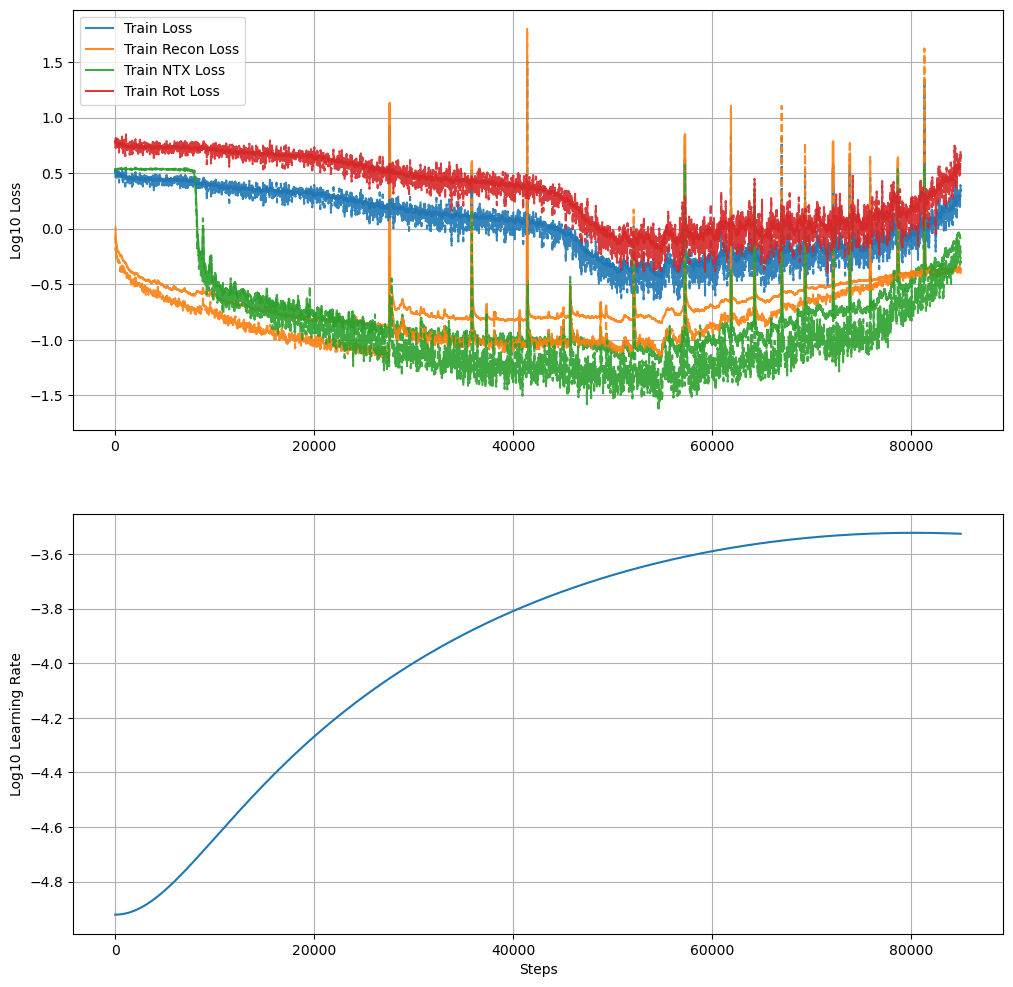

AttributeError: 'function' object has no attribute 'display'

In [51]:
metric.colors = [
            'tab:blue', 'tab:orange', 'tab:green', 'tab:red',
            'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
            'tab:olive', 'tab:cyan', 'tab:blueviolet', 'tab:gold',
            'tab:turquoise', 'tab:coral', 'tab:limegreen', 'tab:indigo'
        ]
plot(metric)

In [14]:
metric.train_data

[(1.8618484735488892, 3.535461902618408, 1.8823505640029907),
 (1.6572937965393066, 3.1298651695251465, 1.847224235534668),
 (1.5589253902435303, 2.9396870136260986, 1.781638503074646),
 (1.3698869943618774, 2.579925775527954, 1.5984816551208496),
 (1.30538010597229, 2.4747657775878906, 1.359945297241211),
 (1.1827179193496704, 2.215503215789795, 1.4993269443511963),
 (1.1163697242736816, 2.0998587608337402, 1.3288072347640991),
 (1.1092936992645264, 2.060397148132324, 1.5819016695022583),
 (1.09804105758667, 2.058471441268921, 1.3761067390441895),
 (1.0674852132797241, 1.9857683181762695, 1.4920200109481812),
 (1.032906174659729, 1.9015265703201294, 1.6428568363189697),
 (1.001493215560913, 1.8744285106658936, 1.2855783700942993),
 (0.9318466782569885, 1.7326916456222534, 1.3100168704986572),
 (0.9593730568885803, 1.8150193691253662, 1.0372669696807861),
 (0.9327646493911743, 1.7282934188842773, 1.372358798980713),
 (0.9398369193077087, 1.7312986850738525, 1.4837515354156494),
 (0.918

In [1]:
1e-4

0.0001

In [11]:
10**(-3.6)

0.00025118864315095795

In [2]:
10**(-3.7)

0.00019952623149688788

In [4]:
10**(-3.8)

0.00015848931924611142

In [15]:
1.5e-4

0.00015